<div style="background-color:#009440; padding: 0px; background-size:cover; background-opacity:50%; border-radius:5px; height:300px">
    <div style="margin: 5px; padding: 10px;">
    <h1 style="color:#00000">Geophysical Data Acquisition and Analysis</h1>
    <h5 style="color:#C0C0C0">LMU, July 24, 2024</h5>
    <h4 style="color:rgba(0,0,0,0.6)">Alice Gabriel, Tobias Megies, Joachim Wassermann</h4>
    </div>
    <div style="float:right; margin: 20px; padding: 20px; background:rgba(255,255,255,0.7); width: 70%; height: 100px">
        <div style="position:relative; top:40%; transform: translateY(-50%)">
        <div style="font-size: x-large; font-weight:900; color:rgba(0,0,0,0.8); line-height:100%">P11 - Seismometer response & equation</div>
        </div>
    </div>
   
</div>

**Please, do not forget to execute Cell 1 first!**

In [2]:
# Cell 1: Preparation for programming
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')                  # do not show warnings
from scipy import interpolate, signal
from time import *
import numpy as np
from obspy import *
from obspy.core import read, UTCDateTime
from obspy.clients.fdsn import Client
from obspy.signal.invsim import paz_to_freq_resp
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import os
import glob
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['figure.facecolor'] = 'w'  # remove grey background


## Exercise 1: Effect of damping on seismometer response

In this exercise we will get acquainted with the seismometer response function. In the code cell below, you will find the poles and zeros of a mechanical seismometer.


a) Estimate the eigenfrequency and the dampig of the system (out of the given impulse response). Plot the amplitude and phase transfer function

b) Change the poles amd zeros to match the following eigenfrequencies and damping pairs 1.0:0.2; 1.0:0.5; 1.0:0.7; 2.0:0.6. Descripe what you see

c) What would change if the sensor is changed to be a electro-dynamic sensor but the impulse still represents a pulse in displacement?


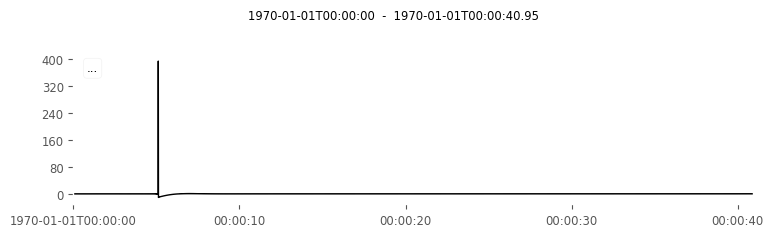

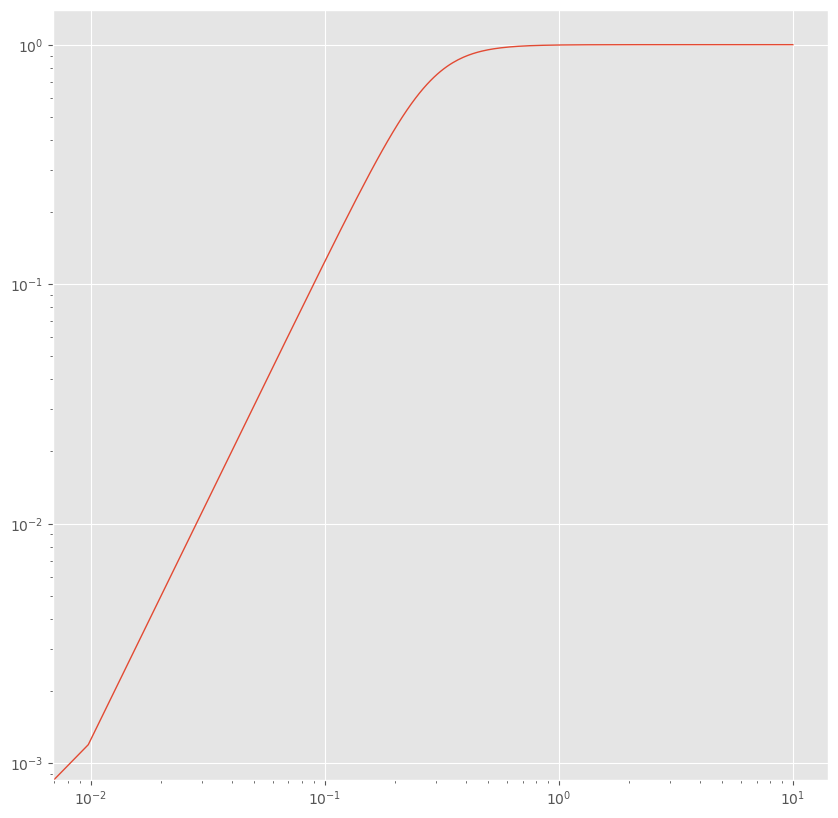

In [44]:
from obspy import *
import numpy as np
paz1 = {'poles': [-1.2566-1.2566j,-1.2566+1.2566j],
            'zeros': [0j,0j],
            'gain': 1.0,
            'sensitivity': 400.0}
tr = Trace()
tr.stats.sampling_rate=100
tr.data = np.zeros(4096)
tr.data[511] = 1.
tr.simulate(paz_simulate=paz1)
tr.plot()
#fft = np.fft.rfft(tr.data)
#freq = np.fft.fftfreq(int(tr.stats.npts/2),d=0.05)
#plt.loglog(freq[:-1],np.abs(fft[1:-1]))

fft,freq = paz_to_freq_resp(paz1['poles'],paz1['zeros'],paz1["gain"],0.05,2048,freq=True)
plt.loglog(freq,np.abs(fft[:]))



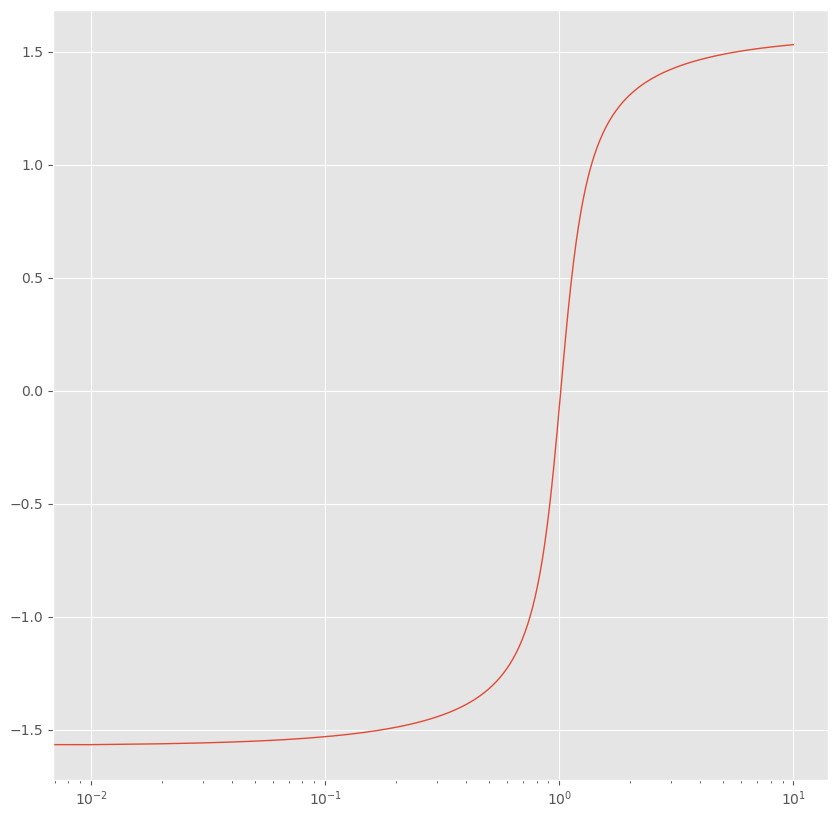

In [27]:
plt.semilogx(freq,np.arctan2(fft.real,fft.imag))

## Exercise 2: Seismometer characteristics

Recall the seismometer equation:

$\ddot{x}_r (t)+ 2\epsilon \dot{x}_r (t) + \omega_0^2 x_r (t) = -\ddot{u}_g$

where $2 \epsilon = \frac{D}{m} = 2h\omega_0$ is the damping factor, $\omega_0$ the natural frequency of the seismometer, $x_r$ the relative displacement of the mass within the seismometer, and $\ddot{u}_g$ the ground accelleration. 


a) What happens to $\ddot{x}_r$ (acceleration of the mass) when the mass moves very rapidly? What does that mean for $\dot{x}_r$ and $x_r$? What does the seismometer measure in that case?

b) Similarly, when the mass moves slowly: what happens to $\ddot{x}_r$ and $\dot{x}_r$? What do you measure? 

c) Can you interpret the two different shapes you saw in 1b) and 1c)? Hint: the output of the cell 3 may help!

### Auxiliary plot: derivatives of source function

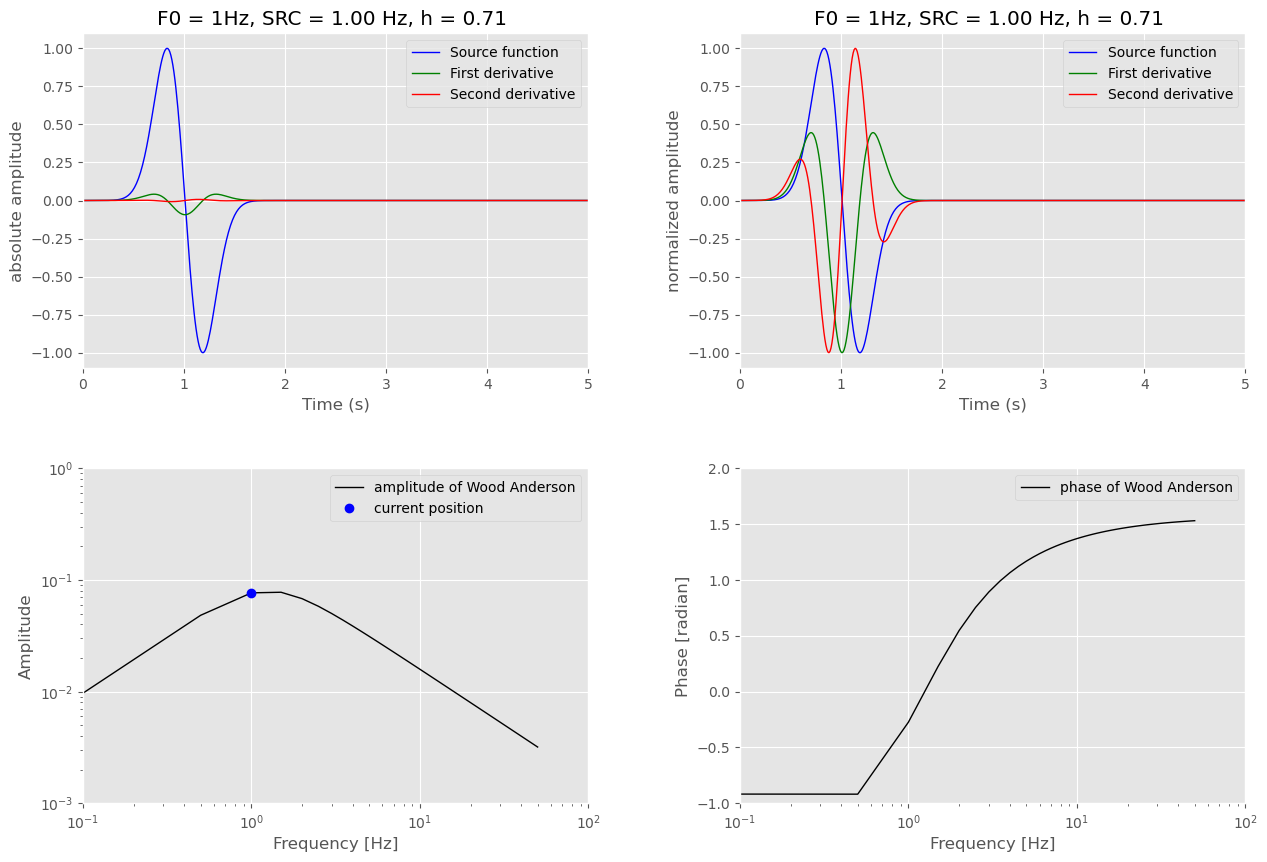

In [33]:
# Cell 3
dt = .01                                                 # time increment for numerical scheme

fu0=1  #you can adjust these parameters
h=0.707  #you can adjust these parameters
f_forcing=1.0 #you can adjust these parameters

# initialize ground motion
p = 1. / f_forcing
nts = int(2. * p / dt)
uii = np.zeros(nts)
t0 = p / dt
a_ricker = 4. / p
for it in range(nts):
    t = (it - t0) * dt
    uii[it] = -2 * a_ricker * t * np.exp(-(a_ricker * t) ** 2)
# end initialize ground motion

nt = int(round(5. * 1. / fu0 / dt))                     # total number of time steps
src = np.zeros(nt)
src[0:len(uii)] = uii

time = np.dot(np.arange(1, nt+1), dt)
source = src[0:nt] / np.max(src[0:nt])
firstderiv =np.gradient(source)
secondderiv = np.gradient(firstderiv)

plt.figure(figsize=(15,10))
plt.subplot(221)
plt.plot(time, source, 'b', label='Source function')
plt.plot(time, firstderiv, 'g', label='First derivative' )
plt.plot(time, secondderiv, 'r', label='Second derivative')
plt.title("F0 = 1Hz, SRC = %.2f Hz, h = %.2f " % (fu0, h))
plt.axis([0, nt*dt, -1, 1])
plt.ylabel("absolute amplitude")
plt.ylim(-1.1,1.1)
#plt.xlim()
plt.xlabel("Time (s)")
plt.legend()

plt.subplot(222)
plt.plot(time, source, 'b', label='Source function')
plt.plot(time, firstderiv/np.max(np.abs((firstderiv))), 'g', label='First derivative' )
plt.plot(time, secondderiv/np.max(np.abs((secondderiv))), 'r', label='Second derivative')
plt.title("F0 = 1Hz, SRC = %.2f Hz, h = %.2f " % (fu0, h))
plt.axis([0, nt*dt, -1, 1])
plt.ylabel("normalized amplitude")
plt.ylim(-1.1,1.1)
plt.xlabel("Time (s)")
plt.legend()

# preparation for subplot 3+4
poles = [-6.2832-4.7124j, -6.2832+4.7124j]
zeros = [0j]
gain = 1.0
h2, f = paz_to_freq_resp(poles, zeros, gain, dt, 200, freq=True)
ind = (f==fu0).nonzero()[0]
amp = abs(h2[ind])
# end preparation subplot 3+4

plt.subplot(223)
plt.loglog(f, abs(h2), 'k', label="amplitude of Wood Anderson")
plt.plot(fu0, amp,'bo', label="current position")
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.ylim(0.001, 1.)
plt.xlim(0.1,100)
plt.legend()

plt.subplot(224)
# take negative of imaginary part, see documentation of paz_to_freq_resp 
phase = np.unwrap(np.arctan2(-h2.imag, h2.real))
plt.semilogx(f, phase, 'k', label="phase of Wood Anderson")
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase [radian]')
plt.xlim(0.1,100)
plt.ylim(-1,2)
plt.legend()

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

## Exercise 3: Seismometer (relative) calibration

In this exercise we want to see if a seismometer deployed in the field is still sane and estimate its gain constant.
Strategy (use extensively the tutorial of ObsPy!):

Use the read function to read in the vertical component noise data from both sensors recorded during the “Huddle” test. The data is stored in the folder LE409. The unkown seismometer has the seed identifier XX.Le409..EH?. Next to it a known instrument was deployed (Trillium Compact: XX.TC120..HH?) and several hours of noise was recorded in parallel. The poles and zeroes of the known instrument are given in the file TCpaz.
Choose a time window (1 hour is sufficient) out of the noise data. Hint: use the trim method of the trace object in ObsPy
Use obspy.signal.calibration.rel_calib_stack module for estimating the unknown frequency response function. Plot the amplitude and the phase response  - what can you report regarding the gain constant of the unknown instrument? NOTE:  The 2nd line in the file TC120paz gives you the number of poles (all poles are following) of the known instrument. Than the number of zeroes are given (followed by all zeroes) and last the gain with the normalization correction is given.


4 Trace(s) in Stream:
XX.Le409..EHZ | 2016-09-06T00:00:00.000000Z - 2016-09-06T08:59:59.780000Z | 200.0 Hz, 6479957 samples
XX.Le409..EHZ | 2016-09-06T09:00:00.000000Z - 2016-09-06T17:00:08.915000Z | 200.0 Hz, 5761784 samples
XX.Le409..EHZ | 2016-09-06T17:01:15.650000Z - 2016-09-06T17:02:24.635000Z | 200.0 Hz, 13798 samples
XX.Le409..EHZ | 2016-09-06T17:03:27.080000Z - 2016-09-06T23:59:59.995000Z | 200.0 Hz, 4998584 samples
1 Trace(s) in Stream:
XX.Le409..EHZ | 2016-09-06T19:00:00.000000Z - 2016-09-06T20:00:00.000000Z | 200.0 Hz, 720001 samples
1 Trace(s) in Stream:
XX.TC120..HHZ | 2016-09-06T19:00:00.000000Z - 2016-09-06T20:00:00.000000Z | 200.0 Hz, 720001 samples


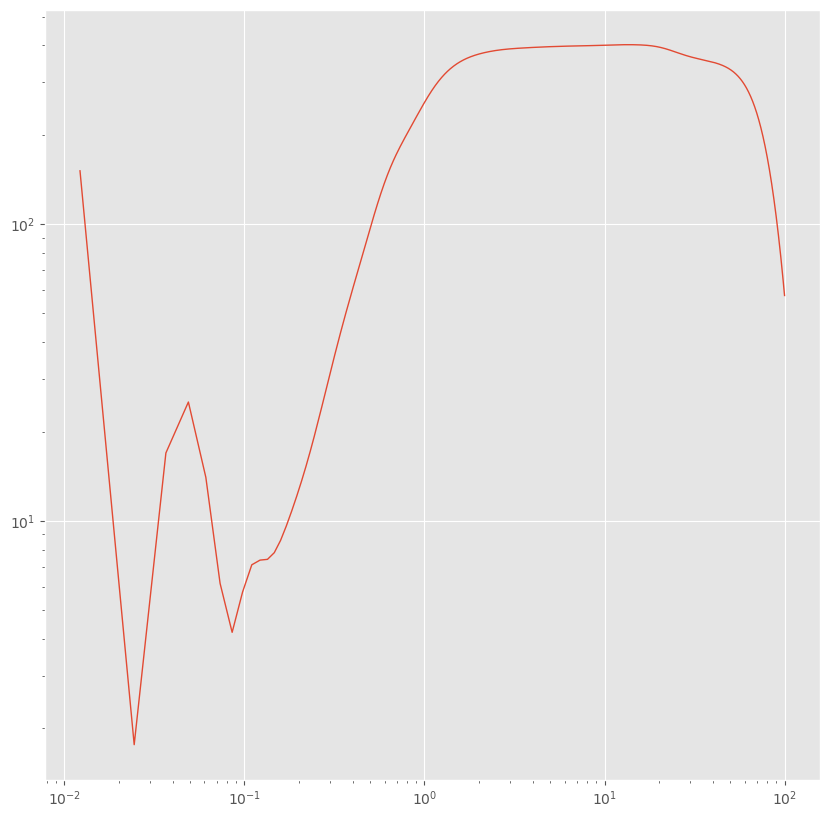

In [55]:
from obspy import *
from obspy.signal.calibration import rel_calib_stack
Le409 = read("./LE409/XX.Le409..EHZ.D.2016.250")
TC120 = read("./LE409/XX.TC120..HHZ.D.2016.250")
print(Le409)

Le409.merge()

t = UTCDateTime(2016,9,6,19)
Le409.trim(t,t+3600)
TC120.trim(t,t+3600)
print(Le409)
print(TC120)

freq,amp,phase = rel_calib_stack(TC120,Le409,"./LE409/TCpaz",50,smooth=10)
plt.loglog(freq,amp)


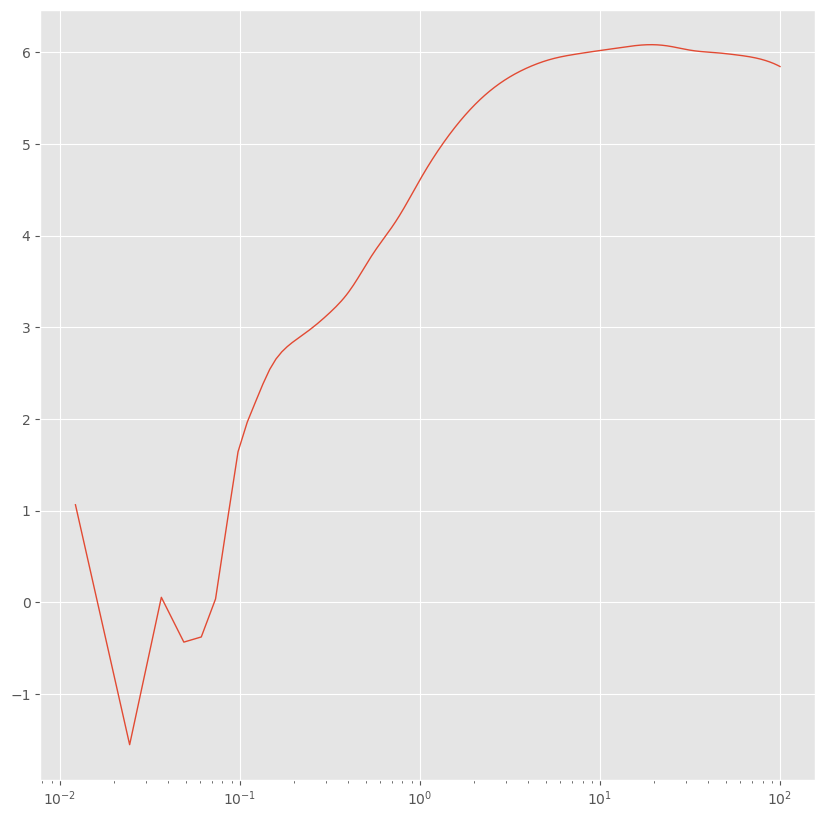

In [54]:
plt.semilogx(freq,phase)
